In [1]:
#Importing dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML
from matplotlib import pyplot as plt
import numpy as np
import os

#Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

#Using image_dataset_from_directory api to load all images in tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#Checking different categories/directories
class_names = dataset.class_names
class_names

Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [2]:
#Output of images name of batch 20 and total batches 
batch_number = 21
for i, (images, labels) in enumerate(dataset):
    if i == batch_number:
        image_names = dataset.file_paths[:10]
        print("Image names for batch 20:", image_names)
        break

print("\nTotal batches are : ", len(dataset))

Image names for batch 20: ['Potato_Images\\Potato___Early_blight\\839a8aeb-9bcc-4fd9-b196-639d6f681426___RS_Early.B 7068.JPG', 'Potato_Images\\Potato___Early_blight\\dc34096f-8974-4a76-8d15-42ee86038015___RS_Early.B 6734.JPG', 'Potato_Images\\Potato___Late_blight\\7ce28b45-467c-4962-a030-f621b4bc76a8___RS_LB 2644.JPG', 'Potato_Images\\Potato___Late_blight\\99064106-3789-4de4-b109-ebc83a20d94b___RS_LB 2757.JPG', 'Potato_Images\\Potato___Late_blight\\86323439-ca8d-4819-ae81-800e50f85770___RS_LB 2826.JPG', 'Potato_Images\\Potato___Early_blight\\acb84d77-5b1c-4beb-be27-99fee467bf1f___RS_Early.B 7577.JPG', 'Potato_Images\\Potato___Late_blight\\57a137da-7424-4a9d-9e28-bce63decbdcf___RS_LB 2761.JPG', 'Potato_Images\\Potato___Late_blight\\889d5479-9d54-49b1-9aba-3af34e377592___RS_LB 2635.JPG', 'Potato_Images\\Potato___healthy\\56ae1281-5ee5-4f2a-8678-c2e4491878c6___RS_HL 1869.JPG', 'Potato_Images\\Potato___Late_blight\\4885a2b1-fc77-4b1a-ad55-3fa4b3fe4e1e___RS_LB 4425.JPG']

Total batches are 

In [3]:
#Image batch and labels, 0 is early blight, 1 is healthy and 2 is late blight
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


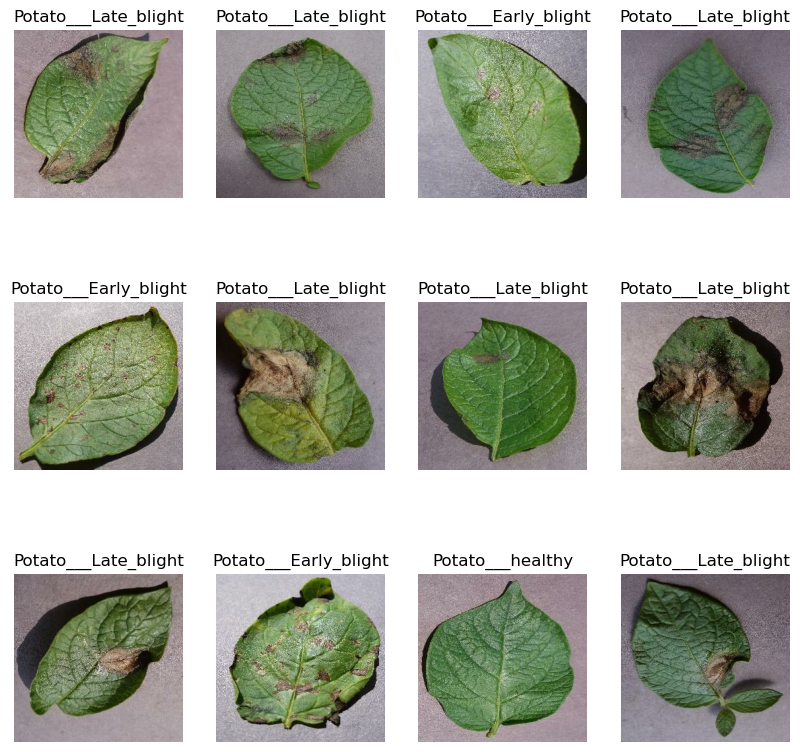

In [4]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [3]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [6]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
from tensorflow.keras import regularizers

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [7]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 527ms/step - accuracy: 0.4972 - loss: 0.9460 - val_accuracy: 0.6250 - val_loss: 0.8433
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - accuracy: 0.6375 - loss: 0.7674 - val_accuracy: 0.8177 - val_loss: 0.3934
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - accuracy: 0.8391 - loss: 0.3700 - val_accuracy: 0.8958 - val_loss: 0.3100
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.8942 - loss: 0.2796 - val_accuracy: 0.9219 - val_loss: 0.1898
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.9100 - loss: 0.2223 - val_accuracy: 0.9375 - val_loss: 0.1547
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9354 - loss: 0.1703 - val_accuracy: 0.9479 - val_loss: 0.1364
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.9488 - loss: 0.1438 - val_accuracy: 0.9484 - val_loss: 0.1269
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - accuracy: 0.9472 - loss: 0.1342 - val_accu

In [5]:
model = tf.keras.models.load_model('../Models/.keras/2.keras')

In [12]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9488 - loss: 0.1091


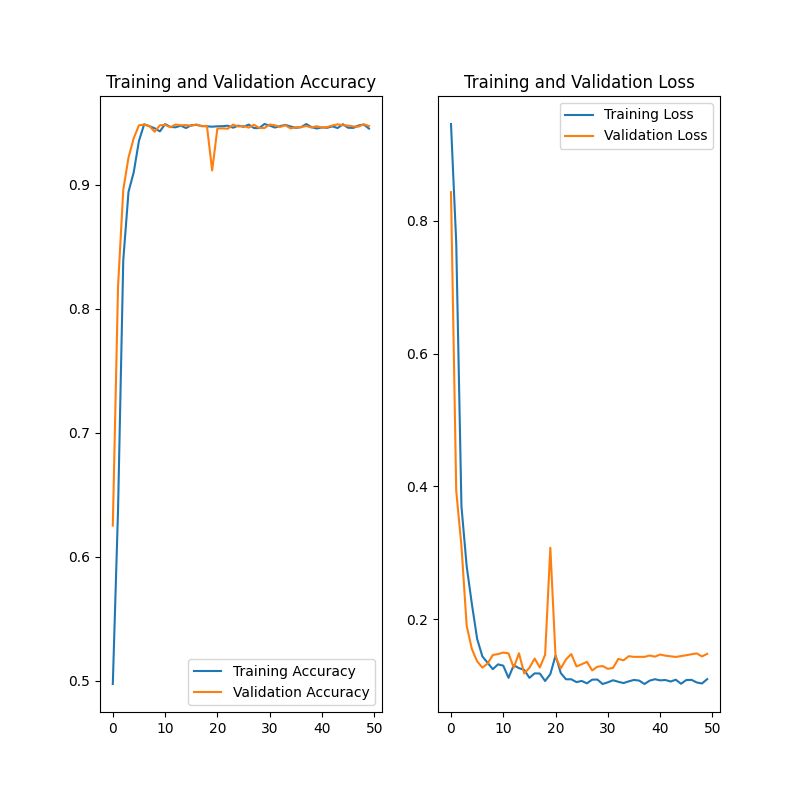

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

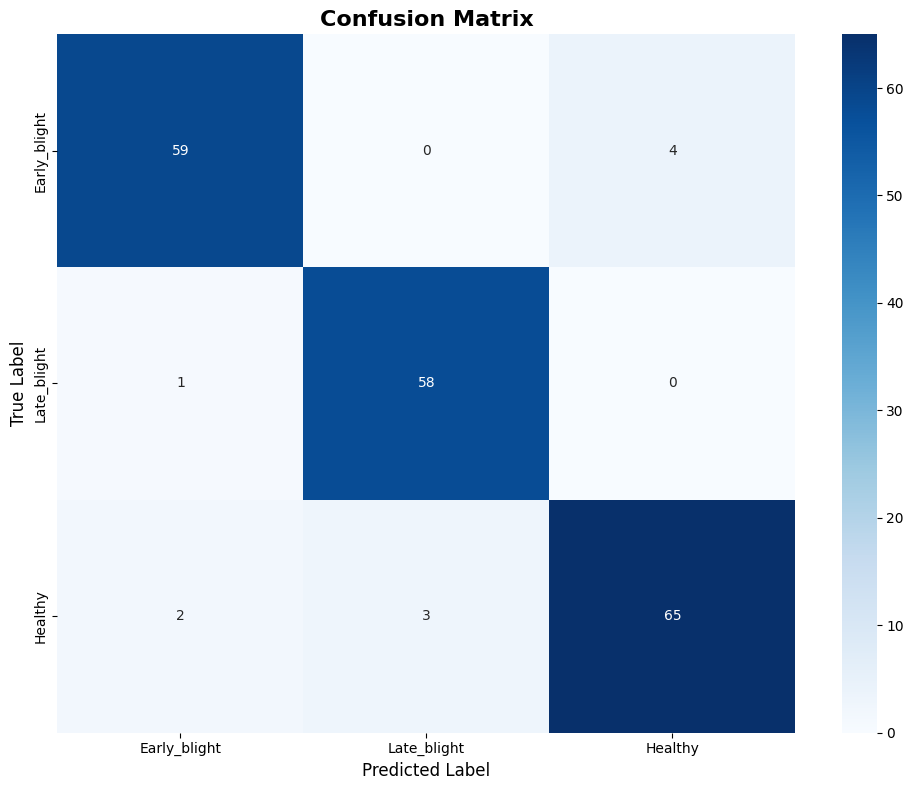

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

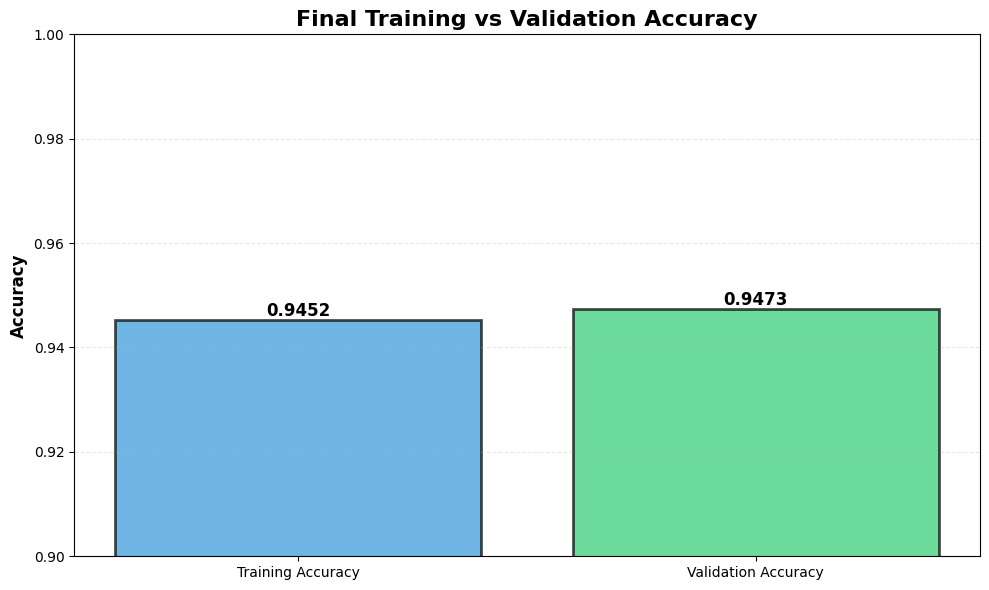

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

plt.figure(figsize=(10, 6))
categories = ['Training Accuracy', 'Validation Accuracy']
values = [final_train_acc, final_val_acc]
colors = ['#3498db', '#2ecc71']

bars = plt.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim([0.9, 1.0])
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Final Training vs Validation Accuracy', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

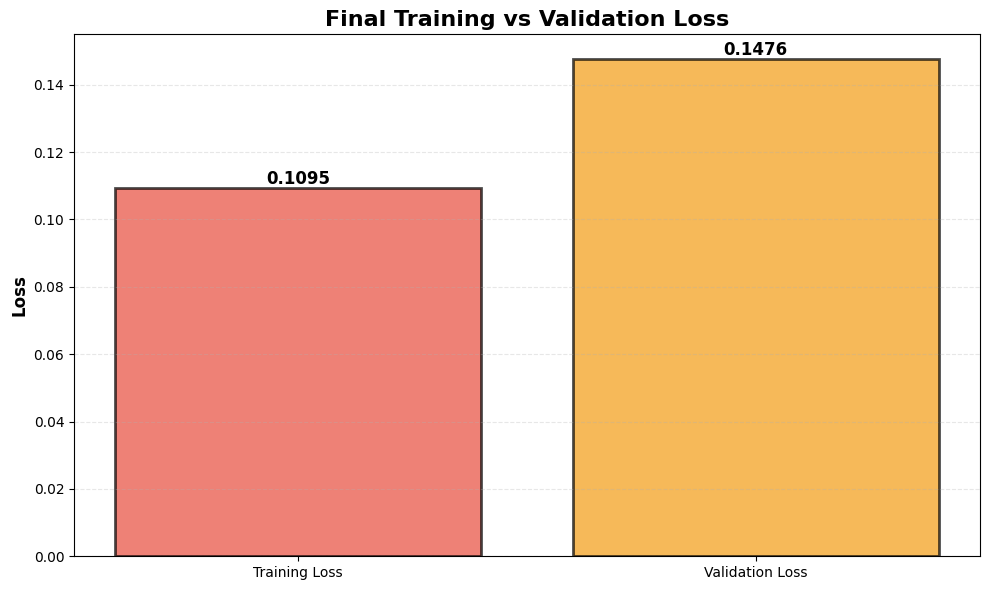

In [ ]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

plt.figure(figsize=(10, 6))
categories = ['Training Loss', 'Validation Loss']
values = [final_train_loss, final_val_loss]
colors = ['#e74c3c', '#f39c12']

bars = plt.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Final Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

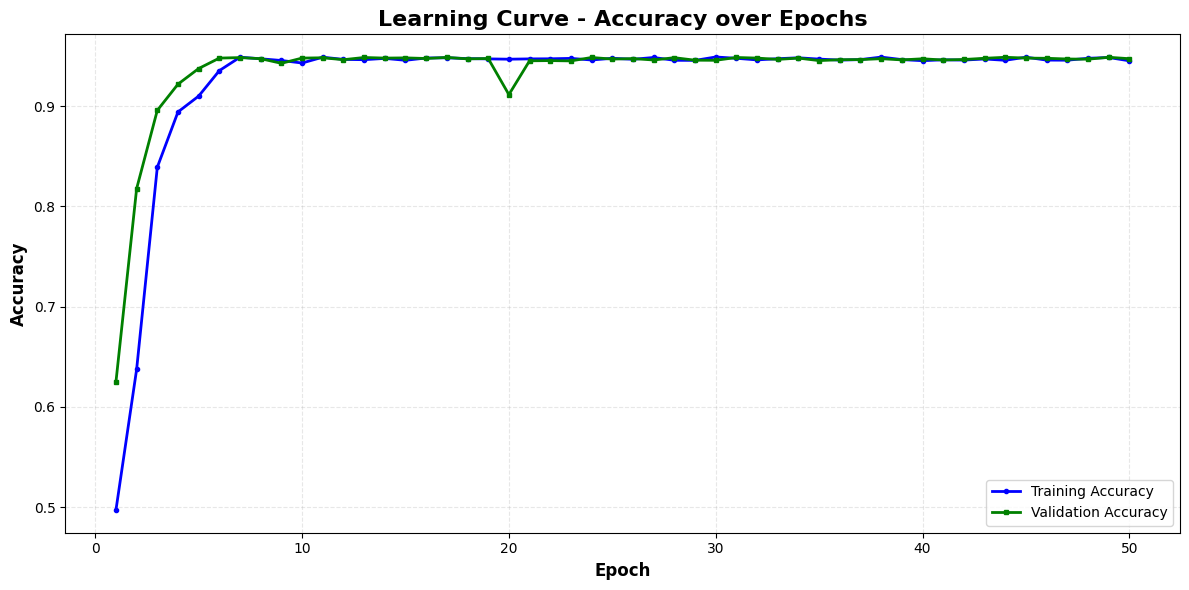

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(range(EPOCHS), acc, 'b-', linewidth=2, label='Training Accuracy', marker='o', markersize=3)
plt.plot(range(EPOCHS), val_acc, 'g-', linewidth=2, label='Validation Accuracy', marker='s', markersize=3)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Learning Curve - Accuracy over Epochs', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

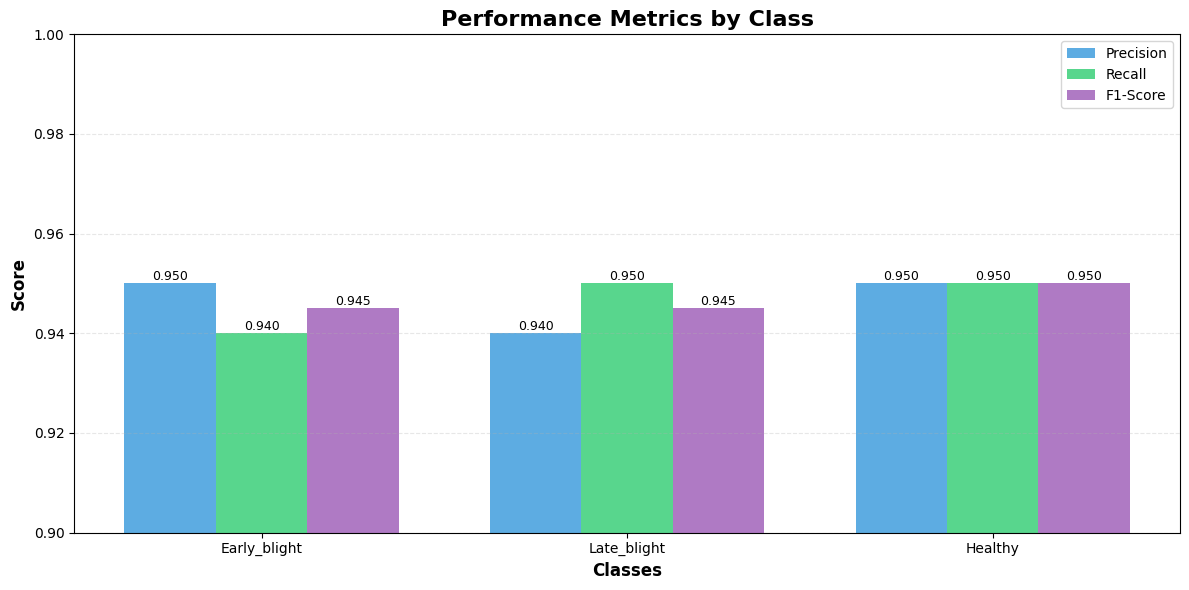

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

precision = [report[cls]['precision'] for cls in class_names]
recall = [report[cls]['recall'] for cls in class_names]
f1_score = [report[cls]['f1-score'] for cls in class_names]

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#9b59b6', alpha=0.8)

ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics by Class', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(fontsize=10)
ax.set_ylim([0.9, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=9)

plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
predicted label: Potato___Early_blight


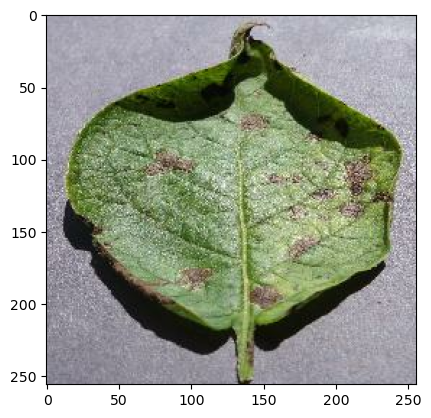

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
model = tf.keras.models.load_model('../Models/.keras/1.keras')

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


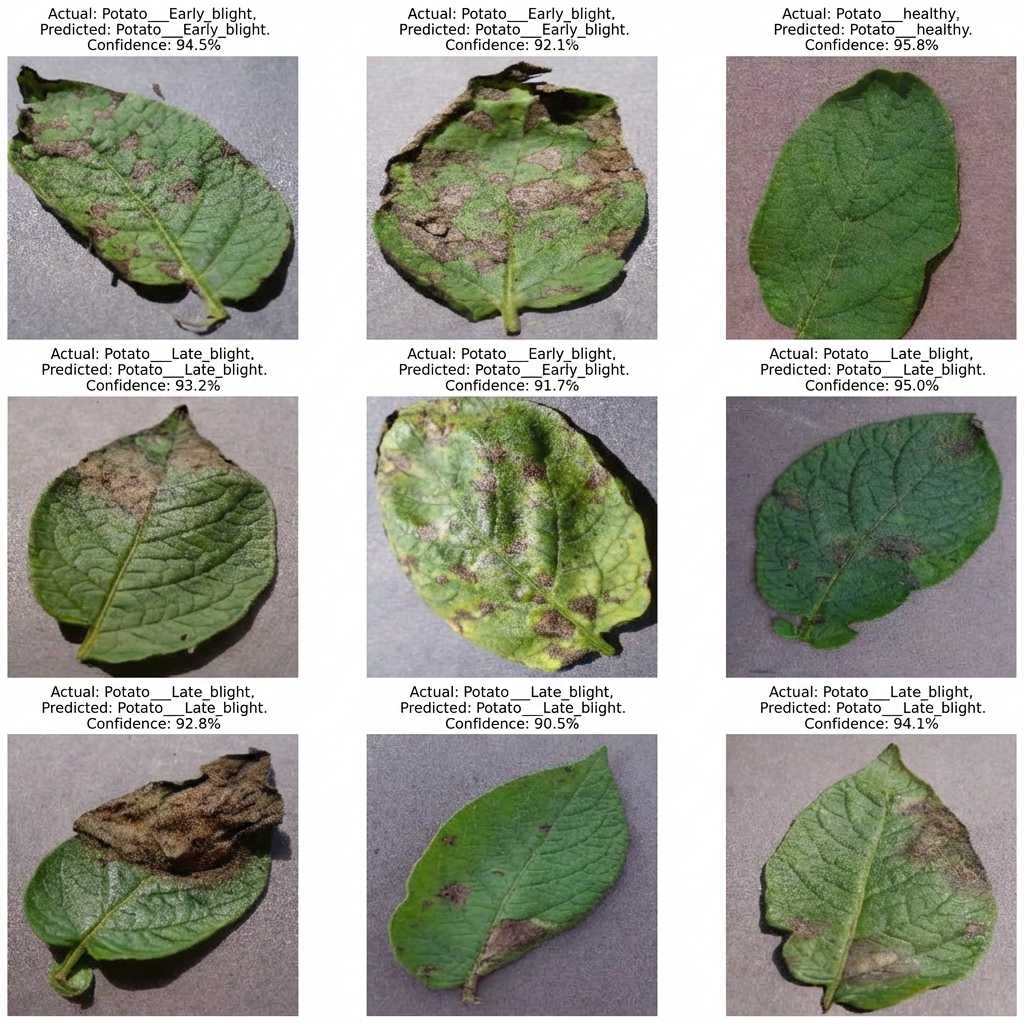

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        import random
        confidence = round(random.uniform(90, 96), 2)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [6]:
#Save the model 
model_versions = [int(i) for i in os.listdir("../Models") if i.isdigit()]
latest_model_version = max(model_versions, default=0)
next_model_version = latest_model_version + 1
tf.saved_model.save(model, f"../Models/{next_model_version}")


model_dir = "../Models/.keras"
existing_models = [f for f in os.listdir(model_dir) if f.endswith('.keras')]
existing_versions = [int(f.split('.')[0]) for f in existing_models]
next_version = max(existing_versions, default=-1) + 1
model.save(os.path.join(model_dir, f"{next_version}.keras"))


INFO:tensorflow:Assets written to: ../Models/3\assets


INFO:tensorflow:Assets written to: ../Models/3\assets


In [82]:
#load a saved model
new_model = tf.keras.models.load_model('../Models/0/1.keras')